<center><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXnrruP7guibF61c4gOESBR2VhhqYmEjKin0yY9lrhCak3hIbXI0QDSlObO74xcBkjMw&usqp=CAU"/></center>

# MAKE GRID - NOTEBOOK VERSION

<small>
🔎 The current interface for creating grids is too heavy to load when the code is run remotely. The aim is to create a notebook(s) that can fulfill the role of the "make_grid.py" code and also edit the mask and bathymetry.
<br>💡 This notebook is linked to the croco-ocean/croco_pytools' <a href= "https://gitlab.inria.fr/croco-ocean/croco_pytools/-/issues/4">ISSUE #4</a> located on the **croco-ocean INRIA's gitlab**
<br>➡️ Notebook created by <a href="mailto:thibault.delahaye@ird.fr">Thibault Delahaye</a> and based on the existing codes of pycrocotool
<br>🌳 Developped on **notebook-grid-tools**'s branch, whose source is the main branch
</small>

---

<div style="text-align: center; font-size: 0.9em; color: gray;">
  
</div>

---

## Table of contents 🔗

1. [Code presentation 📖](#📖-Code-presentation)
   - [💾 Datasets](#💾-Datasets)
   - [⚙️ Requirements](#⚙️-Requirements)
3. [CODE BODY 💻](#💻-CODE_BODY)
   - [✅📋 Prerequisites](✅📋-Prerequisites)
   - [✏️🔧 User's changes](#✏️🔧-User's-changes)
   - [📏 Physical parameters](#📏-Physical-parameters)
   - [🧩 Building the grid](#🧩-Building-the-grid)

---

<div style="text-align: center; font-size: 0.9em; color: gray;">
  
</div>

---

# 📖 Code presentation
*Make sure to [build the croco_pyenv environment](https://croco-ocean.gitlabpages.inria.fr/croco_pytools/prepro/tuto.env.html) before using this notebook.*
## 💾 Datasets

Further Information: [CROCO OCEAN WEBSITE](http://www.croco-ocean.org)
  
*This file is part of CROCOTOOLS* 🐊

**Create a CROCO grid file** 🌐   
In the current state the script can handle:  


<table style="width: 100%; text-align: left; border-collapse: collapse;">
  <thead>
    <tr>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">DATA</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">SOURCE</th>
      <th style="border: 1px solid #ddd; padding: 8px; background-color: #f4f4f4;">FILE EXTENSION</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>Topo/Bathy</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">etopo (5,2,1),<br>srtm30, gebco</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>NetCDF</em></td>
    </tr>
    <tr>
      <td style="border: 1px solid #ddd; padding: 8px;"><strong>Coastline</strong></td>
      <td style="border: 1px solid #ddd; padding: 8px;">GSHHS</td>
      <td style="border: 1px solid #ddd; padding: 8px;"><em>shapefile</em></td>
    </tr>
  </tbody>
</table>

➡️ *To add a new dataset you just have to go into **Readers/topo_readers.py** and
create a dictionnary with the names for lon,lat,topo in the dataset.
At this time it only handles 1D lon/la*  
➡️ *The script makes a grid with **mercator projection** centred at the equator
before rotating the sphere to put the middle of the grid in tra_lon/tra_lat
position.*  
➡️ *Then, it reads topo's dataset and apply the desired smoothing
The mask is generated using a shapefile (.shp. default is gshhs dataset)*  
➡️ *Smoothing uses **fortran routines** for better performance*

### ⚙️ Requirements
➡️ Installing `ipympl` for interactive Plots :

*To use **interactive plotting** features with the `%matplotlib widget` [magic command](#Magic-cells) in Jupyter Notebook or JupyterLab, you need to install the `ipympl` package. This package enables Matplotlib to render interactive plots using Jupyter widgets.*

 **Run the following command** in a code cell or in your notebook to install `ipympl`:
   ```python
   pip install ipympl


---

<div style="text-align: center; font-size: 0.9em; color: gray;">
  
</div>

---

# 💻 CODE_BODY

## ✅📋 Prerequisites

### Magic cells

[Magic cell](https://ipython.readthedocs.io/en/stable/interactive/magics.html) ⚡🐚 dedicated to the activation of backend environments

In [33]:
#Allows widget interactivity with user
%matplotlib widget    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dependencies

In [115]:
import numpy as np
import os,sys
os.environ['ETS_TOOLKIT'] = 'wx'
sys.path.append("./Modules/")
sys.path.append("./Readers/")
sys.path.append("./Modules/graphicUI_tools/")
from main_window import *
import tools_make_grid
#----------------------------------------------#
from tools_make_grid import inputs,inputs_smth,EasyGrid,GetMask,GetTopo
from croco_class import CROCO
from main_window import Outputs
#----------------------------------------------#
from Modules.map_tools.map_tools import plot_grid, plot_outline, plot_topo
from scipy.spatial import distance
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact_manual

## ✏️🔧 User's changes

### Grid's param

#### Center's position (degrees) 📍

In [26]:
tra_lon =  15 # Longitude of the grid center 
tra_lat = -32 # Latitude of the grid center

#### Grid extent (km) and resolution

In [27]:
# Grid size [km]
size_x = 1556
size_y = 1334

# Grid number of points 
# Note: grid resolution is grid size / number of points
nx = 39
ny = 40

#### Grid rotation (degrees)

In [28]:
rot = 0

### Smoothing settings

See [online documentation](https://croco-ocean.gitlabpages.inria.fr/croco_doc/model/model.grid.html) for more details 📚

In [37]:
hmin        = 50    # Minimum depth [m]
hmax        = 6000  # Maximum depth [m]
interp_rad  = 2     # Interpolation radius in number of points (usually between 2 and 8)
rfact       = 0.2   # Maximum r-fact to reach (the lower it is, the smoother it will be)    
smooth_meth = 'lsmooth' # Smoothing method ('smooth', 'lsmooth', 'lsmooth_legacy', 'lsmooth2', 'lsmooth1', 'cond_rx0_topo') 

### Paths

#### Inputs

Topo/bathy file ⛰️ :

In [42]:
topofile = '../../DATASETS_CROCOTOOLS/Topo/etopo2.nc'

Coastline file (for the mask) 🏖️ :

In [43]:
shp_file = '../../DATASETS_CROCOTOOLS/gshhs/GSHHS_shp/i/GSHHS_i_L1.shp'

#### Output(s)

Output grid file 🔲:

In [41]:
output_file="../../CROCO_FILES/croco_grd.nc"


### Mask

Single Connect (Masks water not connected to the main water body) 🎭:

In [44]:
sgl_connect=[False,20,20] # True or False, point indices inside the main water body

## 📏 Physical parameters

In [36]:
r_earth=6371315 # Mean earth radius in meter

## 🧩 Building the grid

### Creating classes for inputs/outputs

In [49]:
inputs=inputs(tra_lon,tra_lat,size_x,size_y,nx,ny,rot)
inputs_smth=inputs_smth(hmin,hmax,interp_rad,rfact,smooth_meth)
outputs=Outputs()

### Create lon/lat grid 

In [58]:
EasyGrid.easygrid(None,inputs,outputs)

### Building the mask and smoothing topo

*Tip: if the ouput is too long 🖱️ right click on the cell annd **"Enable scrolling for outputs"***

In [61]:
GetTopo.topo(None,outputs,topofile,shp_file,smooth=inputs_smth,sgl_connect=sgl_connect)

Reading topography file: ../../DATASETS_CROCOTOOLS/Topo/etopo2.nc
Single region dataset imin/imax= 5534 6165
Bounding indices of the relevant part to be extracted from the entire dataset:
 imin,imax = 5534 6165 out of 10800 jmin,jmax = 1528 1963 out of 5400
Interpolating topography to CROCO grid

 Geographical extents of the dataset:
Finished interpolating
    Longitude min/max =    4.466667   25.500000
    Latitude  min/max =  -39.066666  -24.566668

 Geographical extents of requested ROMS grid:
    Longitude min/max =    4.511359   25.488641
    Latitude  min/max =  -39.031434  -24.631671

 Bounding indices for the portion of dataset covering the entire model grid:
 iwest,ieast =    2   631 out of   632 jsouth,jnorth =    2   434 out of   436

 Averaging window width = 2.00000 in grid spaces.

.........

 Wall Clock time spent to compute hraw    0.04 sec running   1 threads.
 enter smooth_thread r_max = 0.2000000  iters_cond =  500  iters_lin =    0
 set_tiles: nx =  40 ny =  39 numt

_max = 0.2364239
   59     9   39 rx_max = 0.2211276    33   19 ry_max = 0.2357336
   60     9   39 rx_max = 0.2204953    33   19 ry_max = 0.2350567
   61     9   39 rx_max = 0.2198807    33   19 ry_max = 0.2343929
   62     9   39 rx_max = 0.2192831    33   19 ry_max = 0.2337418
   63     9   39 rx_max = 0.2187019    33   19 ry_max = 0.2331031
   64     9   39 rx_max = 0.2181367    33   19 ry_max = 0.2324766
   65     9   39 rx_max = 0.2175870    33   19 ry_max = 0.2318621
   66     9   39 rx_max = 0.2170524    33   19 ry_max = 0.2312592
   67     9   39 rx_max = 0.2165328    33   19 ry_max = 0.2306678
   68     9   39 rx_max = 0.2160282    33   19 ry_max = 0.2300876
   69     9   39 rx_max = 0.2155385    33   19 ry_max = 0.2295184
   70     9   39 rx_max = 0.2150635    33   19 ry_max = 0.2289599
   71     9   39 rx_max = 0.2146030    33   19 ry_max = 0.2284120
   72     9   39 rx_max = 0.2141567    33   19 ry_max = 0.2278744
   73     9   39 rx_max = 0.2137242    33   19 ry_max = 0.2

### Save grid as necdf

This code creates a Netcdf file containing all grid data (geographic, topo-bathymetric, mask) in the format defined by the classes generated earlier in this notebook. Then it saves it in the ouput repertory.

In [67]:
CROCO.create_grid_nc(None,output_file,inputs,outputs)

Writting ../../CROCO_FILES/croco_grd.nc done


---

<div style="text-align: center; font-size: 0.9em; color: gray;">
  The grid has been created, now you can visualize it and edit the mask/bathymetry
</div>

---

## 👁️🌐 Grid display

### Grid's outline

First, to visualize the grid's outline for instance, the map_tools.py plotting functions are usefull:

<GeoAxes: >

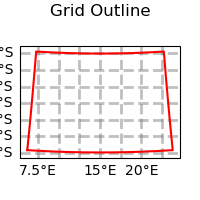

In [83]:
plt.style.use('_mpl-gallery')
figure = plt.figure(figsize = (3,3))
ax = plot_outline(outputs, figure)
figure.suptitle('Grid Outline')
plot_grid(outputs, figure, ax, shp_file ,plot_shape = False)

##### More Arguments:

- **4th argument**: path to the shape file
- **5th argument**: options (choose one):
  - *grid points*
  - *topo*
  - *1/pm*
  - *1/pn*
  - *angle*
  - *mask*
- **6th argument**: set to `True` to plot the shape or `False` to omit it

```python
plot_grid(outputs, figure, ax, shp_file, zview='grid outline', plot_shape=True)

### Adding the topo-bathymetry

🖍️ Plot outline again 

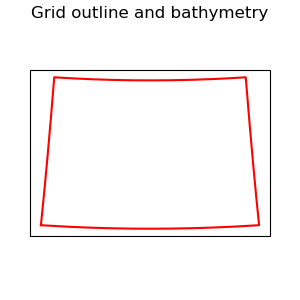

In [107]:
plt.style.use('_mpl-gallery')
figure = plt.figure(figsize = (3,3))
figure.suptitle('Grid outline and bathymetry')
ax = plot_outline(outputs, figure)

🎨 Adding **topo-bathymetry** and the **mask** to the figure

In [108]:
ax, cb = plot_topo(outputs, figure, ax)

## Editing the bathymetry

Flattening and stacking the longitude and latitude data :

In [112]:
x_rho, y_rho = outputs.lon_rho,outputs.lat_rho
data = np.vstack((x_rho.flatten(), y_rho.flatten())).T

<ul>
  <li>
    🌍 <code>x_rho.flatten()</code> and <code>y_rho.flatten()</code> convert the 2D arrays <code>x_rho</code> and <code>y_rho</code> into 1D arrays by flattening them. This process creates a single long array from the 2D grid data.
  </li>
  <li>
    🏗️ <code>np.vstack((x_rho.flatten(), y_rho.flatten()))</code> stacks these 1D arrays vertically, resulting in a 2xN array where N is the total number of grid points.
  </li>
  <li>
    🔄 The <code>.T</code> (transpose) operation converts the 2xN array into an Nx2 array, where each row now contains the longitude and latitude of a single grid point.
  </li>
</ul>

### Widgets and functions to connect to the figure, in order to edit the grid

#### Widget to catch click value and to update it

In [133]:
# Widget to display the old value
def create_old_value_widget():
    global oldValue
    oldValue = widgets.FloatText(
        value=0.0,
        description='Old value:',
        disabled=True
    )
    display(oldValue)

# Widget to input the new value
def create_new_value_widget():
    return interact_manual(update_value, x=widgets.FloatText(
        value=0.0,
        description='New value:'
    ))

#### Functions to select the cell to edit with your mouse 🖱️

In [122]:
# Initialization of global var
focusedPointX, focusedPointY = None, None
oldValue = None
ax, cb = None, None

# Find the closest node
def closest_node(node, nodes):
    """
    Finds the closest node to the given point.
    """
    closest_index = distance.cdist([node], nodes).argmin()
    return closest_index, nodes[closest_index]

# Handle mouse click events
def on_click(event):
    """
    Event handler for mouse clicks on the plot.
    """
    global focusedPointX, focusedPointY
    pt = (event.xdata, event.ydata)
    prox_pt_id, prox_pt_value = closest_node(pt, data)
    
    # Calculate the grid coordinates of the closest point
    p, mod = divmod(prox_pt_id, x_rho.shape[1])
    focusedPointX = p
    focusedPointY = mod
    
    # Update the widget with the old value
    oldValue.value = outputs.h[focusedPointX][focusedPointY]

# Function to update the value at the focused point
def update_value(x):
    """
    Update the value at the focused point and refresh the plot.
    """
    global ax, cb
    if focusedPointX is not None and focusedPointY is not None:
        outputs.h[focusedPointX][focusedPointY] = x
        plt.cla()
        cb.remove()
        ax, cb = plot_topo(outputs, figure, ax)

#### Function to plot an editable map

In [131]:
# Create a new figure and configure events and widgets
def create_new_figure():
    global ax_edit, cb_edit
    
    # Create a new figure
    figure_edit, ax_edit = plt.subplots(figsize = (8,8))  
    ax_edit.set_title("Bathymetry Edit")  
    
    # Initial plot
    ax_edit, cb_edit = plot_topo(outputs, figure_edit, ax_edit)
    
    # Connect mouse events
    figure_edit.canvas.mpl_connect('button_press_event', on_click)
    
    # Create the widgets
    create_old_value_widget()
    create_new_value_widget()
    
    plt.show()  # Display the figure

#### Plot again the map, but this one is editable 🗺️

FloatText(value=0.0, description='Old value:', disabled=True)

interactive(children=(FloatText(value=0.0, description='New value:'), Button(description='Run Interact', style…

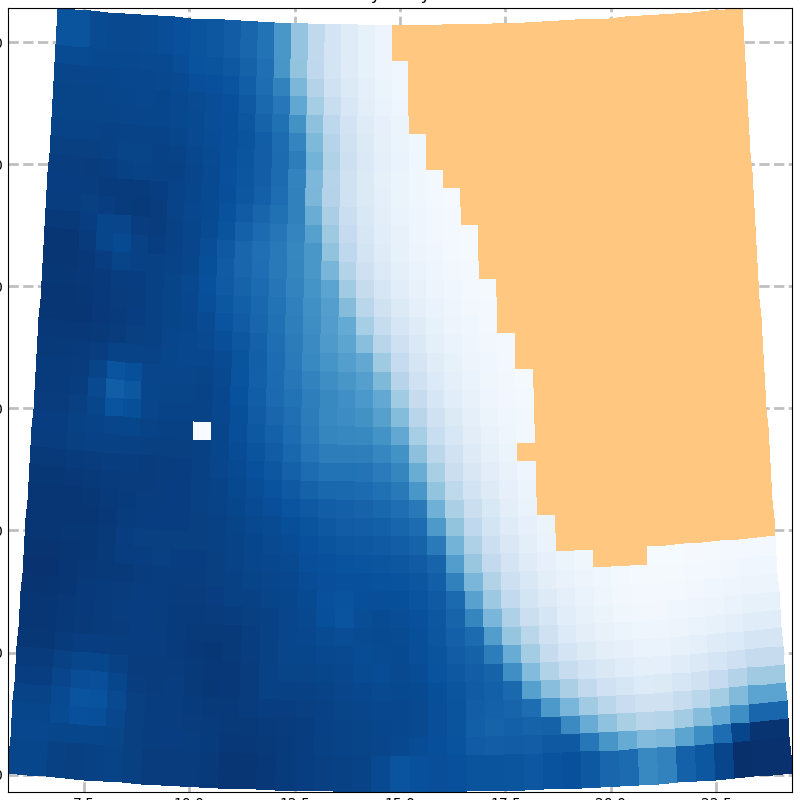

In [134]:
create_new_figure()

### Overwrite the old grid with the new one 📝

In [ ]:
CROCO.create_grid_nc(None,output_file,inputs,outputs)